## Chap7. 7-2 손글씨 이미지 분류하기
6장 6.3절에서 다층 퍼셉트론을 사용해 손글씨 이미지 분류 모형을 학습했다. <br/>
이번에는 합성곱신경망(CNN)으로 손글씨 이미지 분류 모형을 학습해보자.

데이터를 불러오는 단계는 이전 Chap6 6.3 손글씨 이미지 분류와 같다.<br/>
복습겸 다시 한번 코드를 리뷰하자

# #1. 학습 데이터 준비

In [1]:
# PyTorch 라이브러리 임포트

import torch
from torch.autograd import Variable  # torch.autograd.Variable(data)-p18: 텐서를 래핑하고, 계산 과정을 기록하는 역할을 한다.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# scikit-learn 라이브러리 임포트
from sklearn.datasets import load_digits
from sklearn import datasets, model_selection

# pandas 라이브러리 임포트
import pandas as pd

# matplotlib 라이브러리 임포트
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline  # 이미지를 주피터 노트북 안에 출력하도록 함

UsageError: unrecognized arguments: # 이미지를 주피터 노트북 안에 출력하도록 함


In [2]:
mnist = datasets.fetch_openml('mnist_784', data_home='./data/')

In [4]:
mnist['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
mnist['data'][0].shape

(784,)

In [6]:
mnist['target']

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

mnist에는 다음과 같은 필드가 있다.<br/>
* COL_NAMES: 데이터 집합의 각 칼럼명
* DESCR: 데이터 집합 설명
* data: 손글씨 이미지 픽셀값
* target: 손글씨 이미지 숫자 레이블

### 설명변수 정규화

In [7]:
mnist_data = mnist.data / 255

In [8]:
# 데이터 프레임 객체로 변환하고 화면에 출력
pd.DataFrame(mnist_data)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1번 째 이미지를 화면에 출력해본다

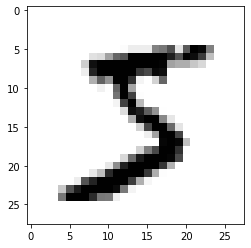

In [9]:
from matplotlib import pyplot as plt

plt.imshow(mnist_data[0].reshape(28, 28), cmap=cm.gray_r)
plt.show()

Malimg 파일도 출력할 수 있을 것 같은데...?

그 전에 이미지를 여러개 출력할 수는 없을까?<br/>
* Reference: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645

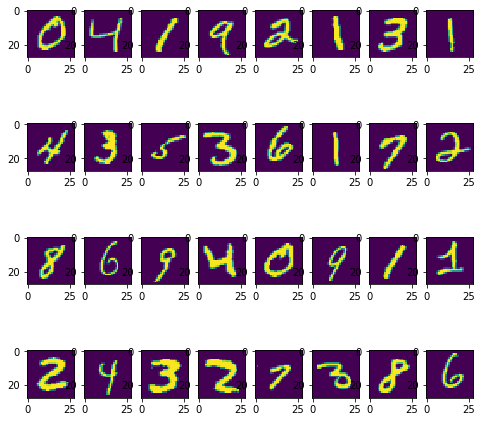

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# w=10
# h=10
fig = plt.figure(figsize=(8,8))
columns = 8
rows = 4

for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h, w))
    img = mnist_data[i].reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

cmap gray 출력

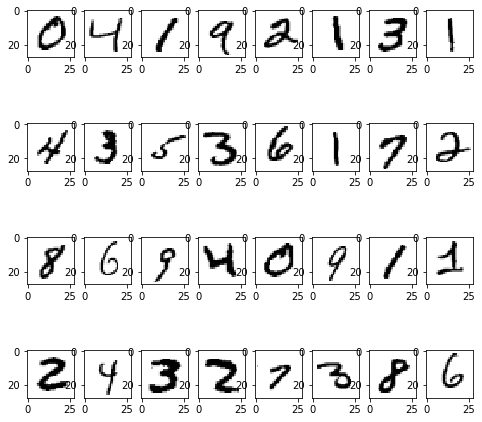

In [11]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig = plt.figure(figsize=(8,8))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h, w))
    img = mnist_data[i].reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap=cm.gray_r)
plt.show()

# #2. Data Preprocessing

* Train_Test_Split()
* 종속변수 데이터 타입 변경하기

In [12]:
# 목적변수를 변수에 할당하고 데이터를 화면에 출력

mnist_label = mnist.target
mnist_label

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

### train_test_split()
70000개의 데이터 중에서 train data는 5000개, test data는 500개를 추출할 수 있도록 한다

In [13]:
# 훈련 데이터 건수 
train_size = 5000  # 5000
# 테스트 데이터 건수
test_size = 500

# 데이터 집합을 훈련 데이터와 테스트 데이터로 분할한다
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(
mnist_data, mnist_label, train_size=train_size, test_size=test_size)

기존에는 test_size parameter값으로 float type값인 0.2를 제공했었다면 이번에는 int형으로 절대값을 제공했다.<br/>
float값을 인자로 줄 경우 test set의 크기는 전체 사이즈에서 입력받은 값의 비율만큼이다.<br/>
<br/>
**sklearn.model_selection.train_test_split()**<br/>
test_size: float, int or None, optional (default=None)<br/>
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split

### MNIST 데이터 종속변수 Data Type 변경하기

train_Y, test_Y의 데이터 타입을 변경해준다.<br/>
float32 타입으로 변경하지 않을 경우, 텐서 생성이 되지 않는 매직...

In [14]:
train_Y

array(['2', '9', '2', ..., '6', '2', '9'], dtype=object)

In [15]:
test_Y

array(['3', '3', '1', '7', '9', '7', '5', '1', '9', '2', '5', '2', '0',
       '6', '2', '9', '2', '1', '4', '0', '9', '2', '7', '6', '9', '1',
       '4', '7', '6', '7', '7', '3', '7', '1', '6', '4', '5', '8', '7',
       '6', '0', '7', '1', '8', '9', '8', '5', '4', '9', '9', '8', '9',
       '1', '5', '6', '5', '3', '1', '4', '4', '6', '7', '4', '7', '4',
       '9', '1', '1', '4', '1', '3', '0', '4', '6', '4', '9', '3', '5',
       '9', '9', '9', '0', '6', '5', '5', '8', '7', '9', '1', '8', '7',
       '0', '1', '0', '8', '3', '4', '7', '8', '3', '7', '0', '6', '2',
       '0', '4', '2', '2', '4', '6', '1', '7', '8', '7', '3', '6', '6',
       '4', '0', '0', '3', '3', '3', '8', '8', '0', '0', '0', '0', '7',
       '3', '4', '9', '6', '1', '8', '9', '0', '2', '8', '7', '9', '8',
       '1', '4', '9', '9', '3', '7', '8', '7', '5', '9', '3', '9', '4',
       '8', '9', '1', '6', '7', '3', '8', '9', '4', '5', '0', '0', '5',
       '7', '6', '4', '4', '2', '1', '7', '3', '7', '0', '5', '1

train set과 test set의 데이터 타입(dtype)이 모두 object로 되어있어 뒤에서 텐서 생성시 오류가 발생한다.<br/>
object type의 데이터를 float타입으로 변경해준다

** float32타입으로 변경하기**

In [16]:
train_Y = train_Y.astype(np.float32)
test_Y = test_Y.astype(np.float32)
print('train_Y의 Data Type: ')
train_Y

train_Y의 Data Type: 


array([2., 9., 2., ..., 6., 2., 9.], dtype=float32)

In [17]:
print('test_Y의 Data Type: ')
test_Y

test_Y의 Data Type: 


array([3., 3., 1., 7., 9., 7., 5., 1., 9., 2., 5., 2., 0., 6., 2., 9., 2.,
       1., 4., 0., 9., 2., 7., 6., 9., 1., 4., 7., 6., 7., 7., 3., 7., 1.,
       6., 4., 5., 8., 7., 6., 0., 7., 1., 8., 9., 8., 5., 4., 9., 9., 8.,
       9., 1., 5., 6., 5., 3., 1., 4., 4., 6., 7., 4., 7., 4., 9., 1., 1.,
       4., 1., 3., 0., 4., 6., 4., 9., 3., 5., 9., 9., 9., 0., 6., 5., 5.,
       8., 7., 9., 1., 8., 7., 0., 1., 0., 8., 3., 4., 7., 8., 3., 7., 0.,
       6., 2., 0., 4., 2., 2., 4., 6., 1., 7., 8., 7., 3., 6., 6., 4., 0.,
       0., 3., 3., 3., 8., 8., 0., 0., 0., 0., 7., 3., 4., 9., 6., 1., 8.,
       9., 0., 2., 8., 7., 9., 8., 1., 4., 9., 9., 3., 7., 8., 7., 5., 9.,
       3., 9., 4., 8., 9., 1., 6., 7., 3., 8., 9., 4., 5., 0., 0., 5., 7.,
       6., 4., 4., 2., 1., 7., 3., 7., 0., 5., 1., 2., 0., 1., 4., 4., 0.,
       3., 0., 7., 7., 7., 7., 0., 3., 3., 1., 1., 1., 8., 1., 7., 3., 0.,
       6., 7., 5., 1., 5., 0., 3., 7., 1., 9., 2., 6., 4., 4., 0., 6., 7.,
       3., 9., 0., 5., 5.

### 길이가 784인 1차원 배열을 28*28 크기의 2차원 배열로 만들어준다.

In [18]:
train_X = train_X.reshape((len(train_X), 1, 28, 28))
test_X = test_X.reshape((len(test_X), 1, 28, 28))

# #3. 텐서 생성

* 텐서 생성
    * 훈련 데이터 텐서 변환
    * 테스트 데이터 텐서 변환
* 설명변수와 목적변수 합치기
* 데이터로더(DataLoader)

In [19]:
# 훈련 데이터 텐서 변환
train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()

# 테스트 데이터 텐서 변환
test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).float()

# 변환된 텐서의 형상 확인
print('train_X.shape: ', train_X.shape)
print('train_Y.shape: ', train_Y.shape)
print('test_X.shape: ', test_X.shape)
print('test_Y.shape: ', test_Y.shape)

train_X.shape:  torch.Size([5000, 1, 28, 28])
train_Y.shape:  torch.Size([5000])
test_X.shape:  torch.Size([500, 1, 28, 28])
test_Y.shape:  torch.Size([500])


### 설명 변수와 목적변수 텐서 합치기
TensorDataset()함수로 설명 변수와 목적변수를 합쳐준다

In [25]:
from torch.utils.data import TensorDataset, DataLoader

# 설명 변수와 목적변수 텐서 합치기
train = TensorDataset(train_X, train_Y)

### 미니배치 분할
DataLoader()함수를 사용해 batch_size만큼 데이터를 불러올 수 있도록 만들어준다

In [21]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)

# #4. 신경망 구성

학습에 사용할 합성곱신경망을 구성한다.<br/>
입력층과 출력층이 각각 1개, 합성곱층 2개와 풀링층 2개, 전결합층 1개로 구성된 중간층을 갖는다.<br/>
입력층의 노드 수는 10개다.<br/>
중간층의 구조에 대한 내용은 뒤에서 보다 자세히 설명한다.

In [22]:
# 신경망의 구성
class Net(nn.Module):  # nn.Module: 모든 신경망의 기본이 되는 클래스이다.
    def __init__(self):
        super(Net, self).__init__()
        # 합성곱층(Convolutional Layer)
        self.conv1 = nn.Conv2d(1, 6, 5)  # 입력 채널 수, 출력 채널 수, 필터 크기
        self.conv2 = nn.Conv2d(6, 16, 5) # Q1. 각각의 값들을 어떻게 정하는 건가요? -20.02.18.Tue pm10:30-
        
        # 전결합층(Fully-connected Layer)
        self.fc1 = nn.Linear(256, 64)  # 256 = (((28-5+1)/2 )-5+1)/2 * (((28-5+1)/2)-5+1)/2 *16
                                       # (1번식)ConV 출력의 크기: 패딩이 없고, 스트라이드는 1일 때 
                                       # ((입력층 노드수(28) + 0(패딩x) - 필터크기(5))/stride(1) + 1)/2
                                       # 풀링계층의 출력값:       ((1번식) -5 + 1)/ 2
                                       # (ConV + Pooling) * (ConV + Pooling) * 16 <- 16은 뭘까?
                                       # 16은 2번째 Conv Layer 출력 채널의 수인데?
                                       # 출력 채널의수?! 
                                       
                                    
                                       # Q. 256라는 숫자가 어떻게해서 나온걸까? -20.02.18.Tue pm 9:30-
                                       
                                       # 지금까지 이해한 내용으로 정리해 봤을 때
                                       # 1. Conv Layer 2개의 층을 지나 256의 노드가 생성된다.
                                       # 2. 256개의 노드를 Fully-Connected Layer에서 64개의 노드로 결합하고
                                       # 3. 다시 Fully-connected Layer를 거쳐 10개의 노드로 출력한다.
                                       # 4. 10개의 노드에 Softmax 함수를 Activation Function으로 줘서 가장 높은 값의 확률값을 얻는다.
                                       # -20.02.18.Tue pm 11:00-
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        # 풀링층
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # 풀링 영역 크기
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # Conv-Activation(ReLU)-MaxPooling: Activation Function으로 ReLU()함수를 제공
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
    
# 인스턴스 생성
model = Net()

# 오차 함수 객체
criterion = nn.CrossEntropyLoss()

# 최적화를 담당할 객체
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 학습 시작
for epoch in range(1000):
    total_loss = 0
    # 분할해 둔 데이터를 꺼내온다
    for train_x, train_y in train_loader:
        # 계산 그래프 구성
        train_x, train_y = Variable(train_x), Variable(train_y)
        # 경사 초기화
        optimizer.zero_grad()
        # 순전파 계산
        output = model(train_x)
        # 오차 계산(loss 계산)
        loss = criterion(output, train_y)
        # 역전파 계산
        loss.backward()
        # 가중치 업데이트
        optimizer.step()
        # 누적 오차 계산
        total_loss += loss.data
        
    # 100회마다 누적 오차 출력
    if (epoch+1) % 100 == 0:
        print('Epoch: ', epoch+1, 'Total loss: ', total_loss)

C:\Users\stevelee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  100 Total loss:  tensor(3.2285)
Epoch:  200 Total loss:  tensor(0.7190)
Epoch:  300 Total loss:  tensor(0.2046)
Epoch:  400 Total loss:  tensor(0.1019)
Epoch:  500 Total loss:  tensor(0.0631)
Epoch:  600 Total loss:  tensor(0.0435)
Epoch:  700 Total loss:  tensor(0.0331)
Epoch:  800 Total loss:  tensor(0.0261)
Epoch:  900 Total loss:  tensor(0.0214)
Epoch:  1000 Total loss:  tensor(0.0180)


hum... 이해가 안가는 부분들이 너무 많군... -20.02.18.Tue pm9:32-

# #6. Accuracy Test

In [23]:
# 계산 그래프 구성
test_x, test_y = Variable(test_X), Variable(test_Y)

# 출력이 0 또는 1이 되게 함
result = torch.max(model(test_x).data, 1)[1]

# 모형의 정확도 측정
accuracy = sum(test_y.data.numpy() == result.numpy()) / len(test_y.data.numpy())

# 모형의 정확도 출력
accuracy

C:\Users\stevelee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.962

단 2개의 합성곱 층으로 이렇게 높은 성능을 보이다니...;; -20.02.18.Tue pm 10:02<br/>
또 한번의 Tutorial은 끝이났다. 문제는 합성곱층, 전결합층, 풀링계층에서 사용되는 함수와 함수가 받는 매개변수의 값이 제대로 이해되지 않을 것 같다